In [1]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using CuPy on an Nvidia GPU


In [2]:
#Lets find some entropy

In [3]:
rmax = 1000000000
num = 500

In [4]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
l=1
q=0
mu=0

In [5]:
#lets define some functions?
def f(r,l=l,q=q,mu=mu,d=d,k=k):
    return k - mu*(r**(2-d)) + (q**2)*(r**(4-2*d)) + (r**2)/(l**2)

def fp(r,l=l,q=q,mu=mu,d=d):
    return (d-2)*mu*(r**(1-d)) + (4-2*d)*(q**2)*(r**(3-2*d))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R)

def gamma2(r0):
    return -1*f(r0)*(r0**(d-2))

In [72]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    rbar = R / 2
    # rgrid = np.linspace(rbar,r0,num)
    rgrid = np.array([np.linspace(rbar,r0,num) for r0 in r0grid])
    return (4 * np.pi / beta(R)) * np.trapz(1/f(rgrid),rgrid)

def k2(r0grid,R):
    rgrid = np.array([np.logspace(np.log10(R),np.log10(rmax),num) for i in range(num)])
    integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0grid)**2))))/f(rgrid)
    return (2*np.pi/beta(R)) * np.trapz(integ,rgrid)

def k3(r0grid,R):
    rgrid = np.array([np.linspace(r0,R,num) for r0 in r0grid])
    integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0grid)**2))))/f(rgrid)
    return (4*np.pi/beta(R)) * np.trapz(integ,rgrid)

In [73]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [80]:
rgrid = np.array([np.logspace(np.log10(10),np.log10(rmax),num) for i in range(num)])
rgrid

array([[1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09],
       [1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09],
       [1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09],
       ...,
       [1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09],
       [1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09],
       [1.00000000e+01, 1.03760502e+01, 1.07662418e+01, ...,
        9.28829225e+08, 9.63757866e+08, 1.00000000e+09]], shape=(500, 500))

In [ ]:
integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(np.linspace(1,100,num))**2))))/f(rgrid)
integ
# ok so i think the issue is that im dividing by the array of r0 guys in all of these. i need to instead do another for loop oh boy!

array([[9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18],
       [9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18],
       [9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18],
       ...,
       [9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18],
       [9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18],
       [9.99000000e-03, 9.27114314e-03, 8.60092212e-03, ...,
        1.15911962e-18, 1.07662418e-18, 1.00000000e-18]], shape=(500, 500))

In [ ]:
(2*np.pi/beta(R)) * np.trapz(integ,rgrid)

In [75]:
#lets get an array relating r0 to alpha for fixed R=10
r0grid = np.linspace(1,100,num)
alphagrid = alpha(r0grid,10)

k1grid = k1(r0grid,10)
k1grid = k1grid.get()

k2grid = k2(r0grid,10)
k2grid = k2grid.get()

k3grid = k3(r0grid,10)
k3grid = k3grid.get()


# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
r0grid = r0grid.get()
alphagrid = alphagrid.get()

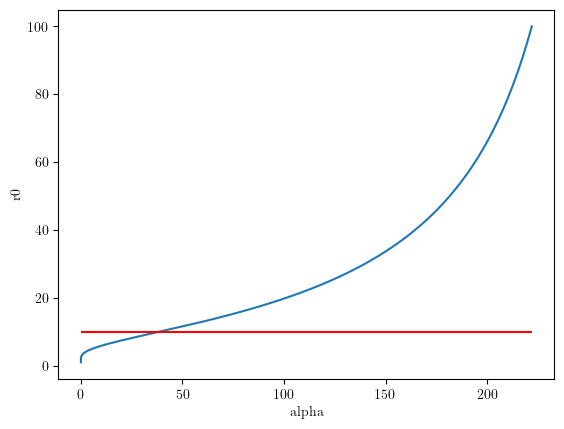

In [77]:
plt.plot(alphagrid,r0grid)
plt.xlabel('alpha')
plt.ylabel('r0')
plt.hlines(10,alphagrid.min(),alphagrid.max(),colors='r')
# plt.semilogx()
plt.show()

In [19]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

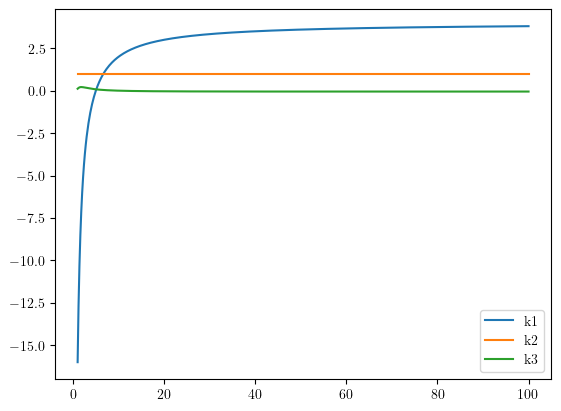

In [79]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.legend()
